In [2]:

# Import Libraries
import torch
import os
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:

# Disable Parallelism (Optional)
# Disable parallelism to avoid issues if running on a local machine
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [4]:

# Define Paths
# Path to fine-tuned model
SCRIPT_DIR = os.getcwd()  # Current working directory
PROJECT_ROOT = os.path.abspath(os.path.join(SCRIPT_DIR, "../../"))
MODEL_PATH = os.path.join(PROJECT_ROOT, "src/transformers/fine_tuned_model")


In [5]:

# Load Model and Tokenizer
# Load the fine-tuned model and tokenizer
print("Loading the fine-tuned model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH)


Loading the fine-tuned model and tokenizer...


In [6]:

# Define Input Text
# Test input
input_text = "[SUBJECT] Question About My iPhone\n[TEXT SO FAR] How "
inputs = tokenizer(input_text, return_tensors="pt")


In [7]:

# Generate Sequences
# Generate multiple sequences with beam search
print("Generating top N inferences...")
beam_outputs = model.generate(
    inputs.input_ids,
    max_length=50,  # Adjust maximum length of generated sequences
    num_beams=10,  # Number of beams for beam search
    num_return_sequences=10,  # Return top N sequences
    output_scores=True,  # Include scores for analysis
    return_dict_in_generate=True,
)


Generating top N inferences...


From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


In [8]:

# Decode and Calculate Scores
# Decode the top N sequences
sequences = [
    tokenizer.decode(seq, skip_special_tokens=True) for seq in beam_outputs.sequences
]

# Compute unnormalized probabilities from beam search scores
# Beam search scores are negative log probabilities -> convert to unnormalized likelihoods
beam_scores = beam_outputs.sequences_scores
unnormalized_likelihoods = torch.exp(
    beam_scores
).tolist()  # Convert log probabilities to unnormalized likelihoods


In [9]:

# Create DataFrame for Visualization
# Create a DataFrame for Seaborn visualization
data = pd.DataFrame(
    {"Inference": sequences, "Unnormalized Likelihood": unnormalized_likelihoods}
)
data = data.sort_values(
    "Unnormalized Likelihood", ascending=False
)  # Sort by likelihood


Visualizing top N inferences...


/var/folders/m1/715mcm_x0x50nchjpzmppnmm0000gp/T/ipykernel_46491/3941794925.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


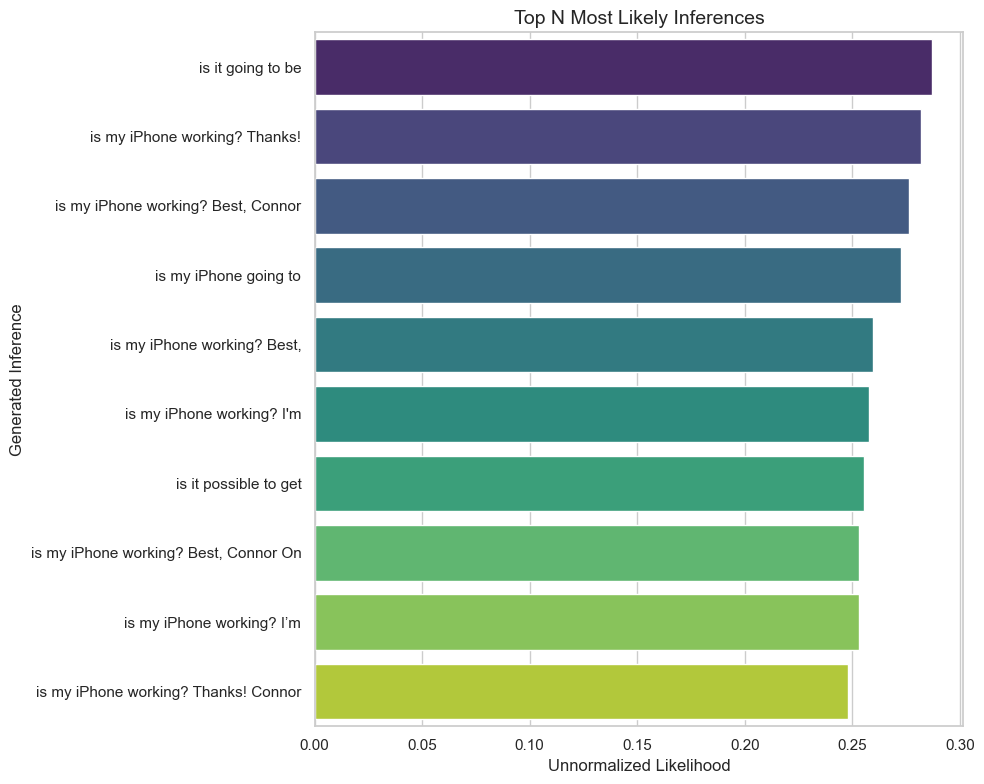

In [10]:

# Visualize with Seaborn
# Visualization with Seaborn
print("Visualizing top N inferences...")
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.barplot(
    data=data,
    y="Inference",  # Most likely at the top
    x="Unnormalized Likelihood",
    palette="viridis",
)
plt.xlabel("Unnormalized Likelihood", fontsize=12)
plt.ylabel("Generated Inference", fontsize=12)
plt.title("Top N Most Likely Inferences", fontsize=14)
plt.tight_layout()
plt.show()
